## Evaluates the circulation budget for ERA5 data (now accessed on NCI)

Creates maps of budget terms at each time step, plots time series of budget terms

Similar to code used on my local machine, but uses area integrals instead of line integrals

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import dask
import dask.diagnostics
from dask.distributed import Client, LocalCluster, Scheduler
import os
import sys

sys.path.append('/home/565/cr7888/PhD/phd_analysis/libraries/')
from budgets import *

In [68]:
try:
    client
except:
    cluster = LocalCluster(n_workers = 2, memory_limit='4GB')
    client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 8,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33271,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 8
Started: 18 minutes ago,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:42259,Total threads: 4
Dashboard: /proxy/44085/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:42841,


In [69]:
g = 9.81 # gravitational constant
R_e = 6371e3 # radius of Earth
R_d = 287 # Dry gas constant

In [70]:
# Pressure levels to average over
min_p = 700
max_p = 900
p = 850

calc_fric = True
column_integrate = True

# box to evaluate the budget over
box_min_lon, box_max_lon = 132, 150
box_min_lat, box_max_lat = -28, -10

# total area plotted in maps (this is the total area evaluated)
min_lon, max_lon = 130, 155
min_lat, max_lat = -30, -5

start_time, end_time = '2019-01-20', '2019-02-10'

# create list of dates to open
date_list = pd.date_range(start_time, end_time)
year = date_list.year[0]

era5_path = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# u_tend_path = '/scratch/k10/cr7888/budget_fran/u_param_tend_plev_2019_fran.nc' 
# v_tend_path = '/scratch/k10/cr7888/budget_fran/v_param_tend_plev_2019_fran.nc'
u_tend_path = '/g/data/k10/cr7888/era5_param_tendencies/u_param_tend_plev.nc' 
v_tend_path = '/g/data/k10/cr7888/era5_param_tendencies/v_param_tend_plev.nc'

### some functions

In [71]:
%%time
%%capture --no-stdout

# Open and subset data

u = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/u/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['u'] # 
v = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/v/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['v']
w = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/w/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['w']
rv = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/vo/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['vo']


u = u.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), 
          longitude=slice(box_min_lon, box_max_lon), latitude=slice(box_max_lat, box_min_lat))
v = v.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), 
          longitude=slice(box_min_lon, box_max_lon), latitude=slice(box_max_lat, box_min_lat))
w = w.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), 
          longitude=slice(box_min_lon, box_max_lon), latitude=slice(box_max_lat, box_min_lat))
rv = rv.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), 
          longitude=slice(box_min_lon, box_max_lon), latitude=slice(box_max_lat, box_min_lat))


# add coords in radians for differentation/integration
u = add_rad_coords(u)
v = add_rad_coords(v)
w = add_rad_coords(w)
rv = add_rad_coords(rv)

CPU times: user 850 ms, sys: 104 ms, total: 954 ms
Wall time: 968 ms


In [72]:
%%time

if calc_fric:
    u_tend = xr.open_dataarray(u_tend_path, chunks={'time': 24, 'pressure': 10})
    v_tend = xr.open_dataarray(v_tend_path, chunks={'time': 24, 'pressure': 10})
    
    u_tend = u_tend.sel(pressure=slice(min_p*100, max_p*100), time=slice(start_time, end_time), 
                        longitude=slice(box_min_lon, box_max_lon), latitude=slice(box_max_lat, box_min_lat))
    v_tend = v_tend.sel(pressure=slice(min_p*100, max_p*100), time=slice(start_time, end_time), 
                        longitude=slice(box_min_lon, box_max_lon), latitude=slice(box_max_lat, box_min_lat))

    u_tend = u_tend.rename({'pressure': 'level'})
    v_tend = v_tend.rename({'pressure': 'level'})

    u_tend['level'] = u_tend['level'] / 100
    v_tend['level'] = v_tend['level'] / 100

    # fill nan values (e.g. below the surface) with 0.
    u_tend = u_tend.fillna(0)
    v_tend = v_tend.fillna(0)
    
u_tend

CPU times: user 29.3 ms, sys: 6.6 ms, total: 35.9 ms
Wall time: 31.9 ms


<xarray.DataArray 'mutpm' (time: 521, latitude: 73, longitude: 73, level: 8)>
dask.array<where, shape=(521, 73, 73, 8), dtype=float64, chunksize=(24, 73, 73, 5), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 132.0 132.2 132.5 132.8 ... 149.5 149.8 150.0
  * latitude   (latitude) float32 -10.0 -10.25 -10.5 ... -27.5 -27.75 -28.0
  * time       (time) datetime64[ns] 2019-01-20T07:00:00 ... 2019-02-10T23:00:00
  * level      (level) float64 700.0 750.0 775.0 800.0 825.0 850.0 875.0 900.0

In [73]:
%%time
u = u.compute()
v = v.compute()
w = w.compute()
rv = rv.compute()
u_tend = u_tend.compute()
v_tend = v_tend.compute()

CPU times: user 4.02 s, sys: 1.24 s, total: 5.26 s
Wall time: 27.3 s


In [74]:
%%time

if calc_fric:
    dav_dt, flux_div, div, adv, tilt, res, fric, res_fric = circulation_budget(
        u, v, w, rv, calc_fric=True, u_param=u_tend, v_param=v_tend, column_integrate=column_integrate)
    dav_dt, flux_div, div, adv, tilt, res, fric, res_fric = dask.compute(dav_dt, flux_div, div, adv, tilt, res, fric, res_fric)
else:
    dav_dt, flux_div, div, adv, tilt, res, _, _ = circulation_budget(u, v, w, rv, column_integrate=column_integrate)
    dav_dt, flux_div, div, adv, tilt, res = dask.compute(dav_dt, flux_div, div, adv, tilt, res)

if not column_integrate:
    dav_dt = dav_dt.sel(level=p)
    flux_div = flux_div.sel(level=p)
    div = div.sel(level=p)
    adv = adv.sel(level=p)
    tilt = tilt.sel(level=p)
    res = res.sel(level=p)
    if calc_fric:
        fric = fric.sel(level=p)
        res_fric = res_fric.sel(level=p)  

CPU times: user 4.03 s, sys: 2.51 s, total: 6.54 s
Wall time: 6.2 s


In [75]:
# take average (trying new version now)
dav_dt_smooth = moving_average(dav_dt)
flux_div_smooth = moving_average(flux_div)
div_smooth = moving_average(div)
adv_smooth = moving_average(adv)
tilt_smooth = moving_average(tilt)
res_smooth = moving_average(res)
if calc_fric:
    fric_smooth = moving_average(fric)
    res_fric_smooth = moving_average(res_fric)

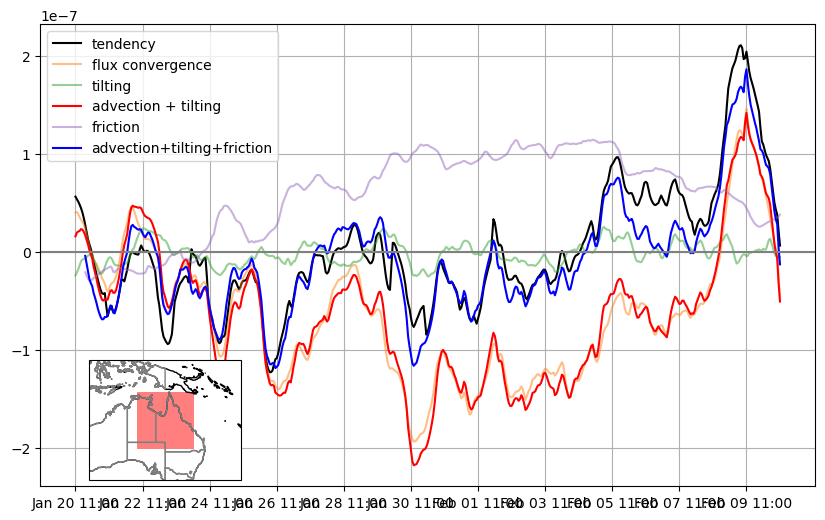

In [76]:
# Time stuff
t = np.arange(len(adv) - 24)
# remove points at end due to 24-point smoothing
times = pd.to_datetime(adv.time.values)[11:-12]
plot_times = times.strftime('%b %d %H:%M')
t = adv.time[11:-12]


fig = plt.figure(figsize=(10,6))
plt.plot(t, dav_dt_smooth, label = 'tendency', color = 'k')
plt.plot(t, -flux_div_smooth, label = 'flux convergence', color = 'tab:orange', alpha=0.5)
#plt.plot(t, -div_smooth, label = 'convergence', linestyle='--', color = 'k')
#plt.plot(t, -adv_smooth, label = 'advection', linestyle=':', color = 'k')
plt.plot(t, -tilt_smooth, label = 'tilting', color = 'tab:green', alpha=0.5)
plt.plot(t, -flux_div_smooth - tilt_smooth, label = 'advection + tilting', color = 'r')
#plt.plot(t, -flux_div_smooth - tilt_smooth, label = 'advection + tilting', color = 'b')
if calc_fric:
    t2 = fric.time[11:-12]
    plt.plot(t2, -fric_smooth, label = 'friction', color = 'tab:purple', alpha=0.5)
    plt.plot(t2, -flux_div_smooth-tilt_smooth-fric_smooth, label='advection+tilting+friction', color='b')
    
plt.axhline(color = 'grey')
#plt.ylim((-2e-10,2e-10))
plt.xticks(t.values[::48], plot_times[::48])
plt.legend(loc='upper left')
plt.grid()


axins = fig.add_axes([0.15, 0.12, 0.2, 0.2], transform=plt.gca().transAxes, projection=ccrs.PlateCarree())
axins.coastlines()
axins.add_feature(cfeature.STATES, edgecolor='gray')
axins.set_extent((box_min_lon - 15, box_max_lon + 15, box_min_lat - 10, box_max_lat + 10), crs=ccrs.PlateCarree())
# Shade box on map inset
lats = [box_min_lat,box_max_lat,box_max_lat,box_min_lat]
lons = [box_min_lon,box_min_lon,box_max_lon,box_max_lon]
xy = np.array([[box_min_lon, box_min_lat], [box_max_lon, box_min_lat], [box_max_lon, box_max_lat], [box_min_lon, box_max_lat]])
poly = Polygon(xy, facecolor='red', alpha=0.5)
plt.gca().add_patch(poly)

In [77]:
# %%time
# # Z_x, Z_y = absolute_vorticity_flux(u, v, w, rv)
# Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y = absolute_vorticity_flux(u, v, w, rv)
# Z_x, Z_y = dask.compute(Z_x, Z_y)
if calc_fric:
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y = absolute_vorticity_flux(u, v, w, rv, fric=True, u_tend=u_tend, v_tend=v_tend)
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y = dask.compute(Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y)
else:
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, _, _ = absolute_vorticity_flux(u, v, w, rv)
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y = dask.compute(Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y)

Z_x

<xarray.DataArray (time: 521, level: 8, latitude: 73, longitude: 73)>
array([[[[ 7.00091318e-04,  6.12270388e-04,  5.36415156e-04, ...,
          -1.62655039e-04, -2.70110698e-04, -1.17650844e-04],
         [ 4.37740644e-04,  4.34874855e-04,  4.21185975e-04, ...,
          -1.11555544e-04, -3.11949003e-04, -2.34383414e-04],
         [ 2.80922272e-04,  3.42169762e-04,  3.74148675e-04, ...,
           1.00783094e-04,  2.52851896e-05, -1.70501151e-04],
         ...,
         [-1.64447729e-04, -1.74884132e-04, -1.42525607e-04, ...,
           5.07040949e-04,  5.53984628e-04,  6.19803022e-04],
         [-1.35445673e-04, -1.39554967e-04, -9.81214816e-05, ...,
           5.12860542e-04,  4.83902082e-04,  4.23474633e-04],
         [-1.21235555e-04, -1.13251738e-04, -1.32491512e-04, ...,
           5.79610256e-04,  2.46857458e-04,  7.45833882e-05]],

        [[ 6.61968615e-04,  6.19748414e-04,  5.68914876e-04, ...,
          -1.51294520e-05, -3.61071441e-04, -3.70226410e-04],
         [ 6.57407214e-04,  6.13457772e-04,  5.69628906e-04, ...,
          -1.46243711e-04, -5.51390283e-04, -4.41088646e-04],
         [ 4.35042808e-04,  4.70970377e-04,  4.80371044e-04, ...,
          -5.26375249e-05, -1.92740483e-04, -1.98069843e-04],
...
         [-6.91732406e-05, -5.56063466e-05, -7.29152668e-05, ...,
          -3.56413733e-04, -3.03855872e-04, -3.48639465e-04],
         [-1.26845961e-04, -1.14527622e-04, -1.38563358e-04, ...,
          -3.63510020e-04, -3.39511670e-04, -4.07665234e-04],
         [-2.48209441e-04, -2.41545552e-04, -2.46080541e-04, ...,
          -3.40872848e-04, -3.42567144e-04, -2.85120253e-04]],

        [[-1.34403276e-04, -1.44427445e-04, -1.21495753e-04, ...,
           2.59330055e-03,  2.30699637e-03,  2.14149265e-03],
         [-1.46179733e-04, -8.92134436e-05, -5.88397528e-05, ...,
           3.15317305e-03,  3.42091794e-03,  2.96132930e-03],
         [-2.54298825e-04, -1.72749096e-04, -1.24547594e-04, ...,
          -7.20385215e-04, -1.24832426e-05,  7.52633561e-04],
         ...,
         [-6.57080604e-05, -6.38324873e-05, -8.44633450e-05, ...,
          -3.31295615e-04, -3.97901047e-04, -5.02958083e-04],
         [-5.02641743e-05, -4.93734806e-05, -6.29952324e-05, ...,
          -3.23409447e-04, -3.10201890e-04, -5.01687177e-04],
         [-1.05640250e-04, -8.69281397e-05, -7.83503518e-05, ...,
          -3.10799268e-04, -2.84241865e-04, -2.98871449e-04]]]])
Coordinates:
  * longitude  (longitude) float32 132.0 132.2 132.5 132.8 ... 149.5 149.8 150.0
  * latitude   (latitude) float32 -10.0 -10.25 -10.5 ... -27.5 -27.75 -28.0
  * level      (level) int32 700 750 775 800 825 850 875 900
  * time       (time) datetime64[ns] 2019-01-20T07:00:00 ... 2019-02-10T23:00:00
    lonrad     (longitude) float32 2.304 2.308 2.313 2.317 ... 2.609 2.614 2.618
    latrad     (latitude) float32 -0.1745 -0.1789 -0.1833 ... -0.4843 -0.4887

In [78]:
total_flux, flux_south, flux_east, flux_north, flux_west = boundary_flux(Z_x, Z_y, column_integrate=column_integrate)
total_adv, adv_south, adv_east, adv_north, adv_west = boundary_flux(adv_x, adv_y, column_integrate=column_integrate)
total_tilt, tilt_south, tilt_east, tilt_north, tilt_west = boundary_flux(tilt_x, tilt_y, column_integrate=column_integrate)
if calc_fric:
    total_fric, fric_south, fric_east, fric_north, fric_west = boundary_flux(fric_x, fric_y, column_integrate=column_integrate)

total_flux

<xarray.DataArray (time: 521)>
array([-2.60694977e-08, -8.45564409e-09,  3.24683715e-09,  2.01538847e-08,
        7.62687063e-08,  2.43384725e-07,  1.54034941e-07,  1.63461832e-07,
        2.24925772e-07,  2.60643006e-07,  2.15390584e-07,  8.30943146e-08,
       -4.60684398e-08, -1.21130050e-07, -5.95083562e-08, -6.08596371e-08,
       -1.12556446e-07, -1.20976446e-07, -1.10340076e-07, -4.85029404e-08,
       -1.02671300e-07, -2.25128150e-07, -2.57345135e-07, -2.45813794e-07,
       -2.21489840e-07, -1.95019344e-07, -1.85257280e-07, -7.71571339e-08,
        2.84902912e-09,  7.27662473e-08,  4.49621636e-08,  4.02012794e-08,
        8.25880002e-08,  1.47572143e-07,  1.21195397e-07,  2.30112427e-08,
       -4.27379282e-08, -6.58224100e-08, -6.45401230e-08, -3.18418723e-08,
        2.75285185e-08, -4.01985362e-09, -1.22188371e-07, -2.11164284e-07,
       -1.21983476e-07, -1.20993517e-07, -9.51166015e-08, -7.55977734e-08,
       -1.12490364e-08,  2.96327016e-08,  6.54812485e-08,  6.16889247e-08,
        1.15219063e-07,  1.92067770e-07,  3.04274592e-07,  2.74373573e-07,
        2.34164382e-07,  1.77037491e-07,  7.41557489e-08,  2.88751025e-09,
       -7.16484690e-08, -8.54165990e-08, -5.51787035e-08, -4.94339862e-08,
       -4.89233724e-08, -7.37797871e-08, -1.54069451e-07, -1.44966529e-07,
       -7.25898032e-08, -1.33310961e-07, -1.73076661e-07, -1.60030800e-07,
       -1.18337919e-07, -9.44223488e-08, -3.57761976e-08, -2.93957752e-08,
       -9.57786864e-08, -1.54667683e-07, -1.08072244e-07,  5.98019957e-08,
...
        1.65085017e-07,  1.27957615e-07,  3.90316530e-08,  5.31489554e-08,
        4.02617388e-08,  5.83479444e-08,  6.61047040e-08,  2.79447087e-08,
       -1.35064075e-08, -7.23761229e-08, -1.46736754e-07, -2.13360630e-07,
       -2.23723763e-07, -8.30474171e-08, -1.44028079e-07, -4.56222065e-08,
       -3.58160205e-09,  4.66594168e-08,  9.30847088e-08,  1.01455247e-07,
        1.07824444e-07,  1.38394064e-07,  1.31727877e-07,  1.66696607e-07,
        2.07667472e-07,  2.00559674e-07,  1.62730149e-07,  1.36135230e-07,
        1.41694778e-07,  1.97932605e-07,  2.01826644e-07,  1.49631332e-07,
        1.14781405e-07,  1.25916855e-07,  1.40276214e-07,  1.44285810e-07,
        1.43606209e-07,  1.55563984e-07,  1.52459079e-07,  3.14922203e-08,
        1.43546275e-07,  1.95893712e-07,  2.16516425e-07,  1.17831985e-07,
        1.48302971e-07,  2.23286137e-07,  2.95711110e-07,  2.54029081e-07,
        2.50599360e-07,  1.56695380e-07,  7.05853758e-08,  5.11980927e-07,
        3.28686291e-07, -1.57958992e-07, -8.74007796e-08, -7.69110339e-08,
       -2.85559243e-08, -1.56607810e-08, -6.55354194e-09,  1.66798002e-08,
       -2.43553662e-08, -5.74342312e-09, -4.60040846e-08, -1.26461841e-09,
        7.20394896e-08,  4.74590593e-08,  8.22773227e-08,  8.44667663e-08,
        9.88562471e-08,  7.35093796e-08,  3.56174578e-09, -5.10858827e-08,
       -5.20026616e-08, -4.12459458e-08, -4.38364855e-08, -7.49856330e-08,
       -7.27733941e-08])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-20T07:00:00 ... 2019-02-10T23:00:00

In [79]:
total_flux_smooth = moving_average(total_flux)
flux_south_smooth = moving_average(flux_south)
flux_east_smooth = moving_average(flux_east)
flux_north_smooth = moving_average(flux_north)
flux_west_smooth = moving_average(flux_west)

total_adv_smooth = moving_average(total_adv)
adv_south_smooth = moving_average(adv_south)
adv_east_smooth = moving_average(adv_east)
adv_north_smooth = moving_average(adv_north)
adv_west_smooth = moving_average(adv_west)

total_tilt_smooth = moving_average(total_tilt)
tilt_south_smooth = moving_average(tilt_south)
tilt_east_smooth = moving_average(tilt_east)
tilt_north_smooth = moving_average(tilt_north)
tilt_west_smooth = moving_average(tilt_west)

if calc_fric:
    total_fric_smooth = moving_average(total_fric)
    fric_south_smooth = moving_average(fric_south)
    fric_east_smooth = moving_average(fric_east)
    fric_north_smooth = moving_average(fric_north)
    fric_west_smooth = moving_average(fric_west)

if not column_integrate:
    total_flux_smooth = total_flux_smooth.sel(level=p)
    flux_south_smooth = flux_south_smooth.sel(level=p)
    flux_east_smooth = flux_east_smooth.sel(level=p)
    flux_north_smooth = flux_north_smooth.sel(level=p)
    flux_west_smooth = flux_west_smooth.sel(level=p)

    total_adv_smooth = total_adv_smooth.sel(level=p)
    adv_south_smooth = adv_south_smooth.sel(level=p)
    adv_east_smooth = adv_east_smooth.sel(level=p)
    adv_north_smooth = adv_north_smooth.sel(level=p)
    adv_west_smooth = adv_west_smooth.sel(level=p)

    total_tilt_smooth = total_tilt_smooth.sel(level=p)
    tilt_south_smooth = tilt_south_smooth.sel(level=p)
    tilt_east_smooth = tilt_east_smooth.sel(level=p)
    tilt_north_smooth = tilt_north_smooth.sel(level=p)
    tilt_west_smooth = tilt_west_smooth.sel(level=p)

    if calc_fric:
        total_fric_smooth = total_fric_smooth.sel(level=p)
        fric_south_smooth = fric_south_smooth.sel(level=p)
        fric_east_smooth = fric_east_smooth.sel(level=p)
        fric_north_smooth = fric_north_smooth.sel(level=p)
        fric_west_smooth = fric_west_smooth.sel(level=p)

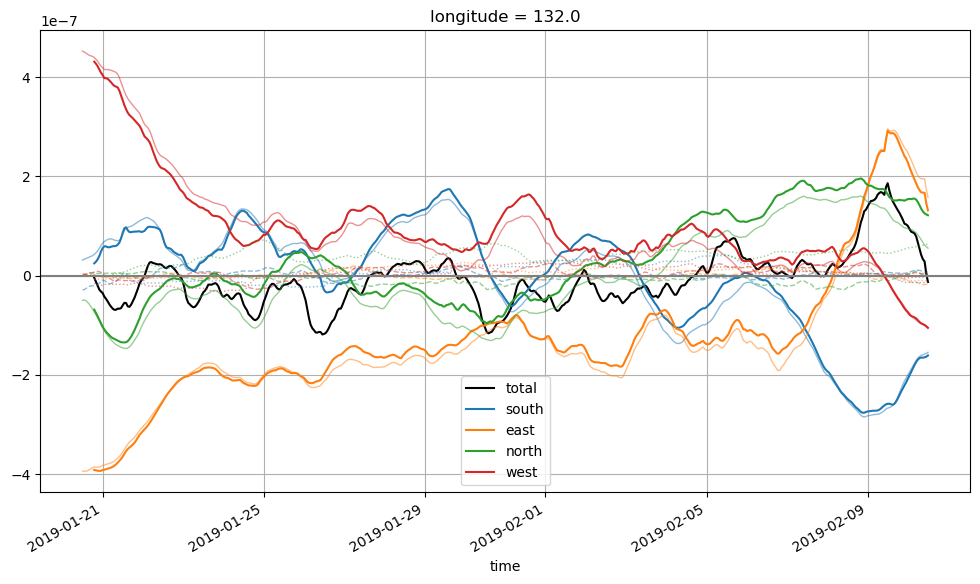

In [80]:
plt.figure(figsize=(12, 6))

total_flux_smooth.plot(label='total', color='k')

flux_south_smooth.plot(label='south', color='tab:blue')
adv_south_smooth.plot(color='tab:blue', linestyle='-', alpha=0.5, linewidth=1)
tilt_south_smooth.plot(color='tab:blue', linestyle='--', alpha=0.5, linewidth=1)

flux_east_smooth.plot(color='tab:orange', label='east')
adv_east_smooth.plot(color='tab:orange', linestyle='-', alpha=0.5, linewidth=1)
tilt_east_smooth.plot(color='tab:orange', linestyle='--', alpha=0.5, linewidth=1)

flux_north_smooth.plot(color='tab:green', label='north')
adv_north_smooth.plot(color='tab:green', linestyle='-', alpha=0.5, linewidth=1)
tilt_north_smooth.plot(color='tab:green', linestyle='--', alpha=0.5, linewidth=1)

flux_west_smooth.plot(color='tab:red', label='west')
adv_west_smooth.plot(color='tab:red', linestyle='-', alpha=0.5, linewidth=1)
tilt_west_smooth.plot(color='tab:red', linestyle='--', alpha=0.5, linewidth=1)

if calc_fric:
    fric_south_smooth.plot(color='tab:blue', linestyle=':', alpha=0.5, linewidth=1)
    fric_east_smooth.plot(color='tab:orange', linestyle=':', alpha=0.5, linewidth=1)
    fric_north_smooth.plot(color='tab:green', linestyle=':', alpha=0.5, linewidth=1)
    fric_west_smooth.plot(color='tab:red', linestyle=':', alpha=0.5, linewidth=1)


plt.grid()
plt.axhline(color='grey')

plt.legend()